# Challenge $0$


## 1. ***Data cleaning with Pandas***

Use the library `pandas` to load and clean the required dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

Obtain the data file

In [3]:
FFILE = './50_Startups.csv'
if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !curl "https://raw.github.com/alexdepremia/ML_IADA_UTs/main/challenge_0/50_Startups.csv"
else:
    print("Either the file is missing or not readable, download it")
    !curl "https://raw.github.com/alexdepremia/ML_IADA_UTs/main/challenge_0/50_Startups.csv"

File already exists
File is readable


In [4]:
import pandas as pd

# Load the dataset using Pandas
data = pd.read_csv('50_Startups.csv')

# Extracting the features (independent variables) and labels (dependent variable)
# Features (X) are taken from all columns except the last two
features = data.iloc[:, :-2].values

# Labels (y) are taken from the third column (index 3, considering the 0-based index in Python)
labels = data.iloc[:, 3].values

df = pd.DataFrame(data)

In [5]:
labels

array(['New York', 'California', 'Florida', 'New York', 'Florida',
       'New York', 'California', 'Florida', 'New York', 'California',
       'Florida', 'California', 'Florida', 'California', 'Florida',
       'New York', 'California', 'New York', 'Florida', 'New York',
       'California', 'New York', 'Florida', 'Florida', 'New York',
       'California', 'Florida', 'New York', 'Florida', 'New York',
       'Florida', 'New York', 'California', 'Florida', 'California',
       'New York', 'Florida', 'California', 'New York', 'California',
       'California', 'Florida', 'California', 'New York', 'California',
       'New York', 'Florida', 'California', 'New York', 'California'],
      dtype=object)

***Play with data***

In [6]:
df.shape

(50, 5)

In [7]:
df.replace(to_replace = 0.00, value = df.mean(axis=0, numeric_only=True), inplace=True)  # inject the mean of the column when value is 0
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


 **`df.replace()` function:**
   - This function is used to replace specific values within a DataFrame (`df`) with another value.
   - The parameters used are:
     - `to_replace=0.00`: This specifies the value in the DataFrame that needs to be replaced, in this case, `0.00`.
     - `value=df.mean(axis=0)`: This sets the replacement value for the matched condition. Here, `df.mean(axis=0)` calculates the mean for each column along the rows (axis=0) of the DataFrame `df`. The mean value for each column will replace the `0.00` values.
     - `inplace=True`: This parameter ensures that the modification is done directly on the original DataFrame (`df`) without creating a new DataFrame. If `inplace` is set to `True`, the original DataFrame is modified.

***Select two categories for binary classification***

In [8]:
df_sel=df[(df.State=="California") | (df.State=="Florida")]

In [9]:
df_sel.head() # column title and first rows of the dataset

,R&D Spend,Administration,Marketing Spend,State,Profit
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
4,142107.34,91391.77,366168.42,Florida,166187.94
6,134615.46,147198.87,127716.82,California,156122.51
7,130298.13,145530.06,323876.68,Florida,155752.60


In [10]:
df_sel.dtypes # type of each column

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

***Encode categorical data***

One-hot encoding of categorical feature _State_

One-Hot Encoding is a technique used in machine learning to handle categorical variables by transforming them into a format that can be easily utilized by algorithms.

Imagine having a categorical variable, such as colors: red, green, and blue. With One-Hot Encoding, each color becomes a new binary column. If an observation has a specific color, the column corresponding to that color will be set to 1, while the other columns will be set to 0.

For example:
- If you have categories "red", "green", "blue", and you want to encode them using One-Hot Encoding:
  - "red" becomes [1, 0, 0]
  - "green" becomes [0, 1, 0]
  - "blue" becomes [0, 0, 1]

This helps machine learning algorithms to understand and work with these categorical variables more effectively, as it doesn't impose an order or hierarchy among the categories but rather represents them in a form that the algorithm can interpret more efficiently.

In [11]:
df_one = pd.get_dummies(df_sel["State"], dtype=int)

In [12]:
df_one.head()

,California,Florida
1,1,0
2,0,1
4,0,1
6,1,0
7,0,1


In [13]:
# Constructing the final dataset for learning and prediction

# Concatenating two DataFrames 'df_one' and 'df_sel' along columns (axis=1)
df_fin = pd.concat((df_one, df_sel), axis=1)

# Dropping the column "Florida" from the dataset as it was not selected for the final model
df_fin = df_fin.drop(["Florida"], axis=1)

# Dropping the column "State" (assumed to be the original 'State' column) as it is not required in its original form
df_fin = df_fin.drop(["State"], axis=1)

# Renaming the column "California" to "State" as part of preparing the dataset for classification (1 for California, 0 for Florida)
df_fin = df_fin.rename(columns={"California": "State"})

# Displaying the initial rows of the modified final dataset
df_fin.head()

,State,R&D Spend,Administration,Marketing Spend,Profit
1,1,162597.70,151377.59,443898.53,191792.06
2,0,153441.51,101145.55,407934.54,191050.39
4,0,142107.34,91391.77,366168.42,166187.94
6,1,134615.46,147198.87,127716.82,156122.51
7,0,130298.13,145530.06,323876.68,155752.60


***Normalize***

Divide by the absolute value of the maximum so that features are in \[0, 1\]

In [14]:
def absolute_maximum_scale(series):
    """
    Scale each column in the DataFrame 'df_fin' by dividing the values by the absolute maximum value of that column.

    Args:
    series: A pandas Series or DataFrame column to be scaled.

    Returns:
    A scaled version of the input series with values ranging from -1 to 1 based on the maximum absolute value in the column.
    """
    return series / series.abs().max()

In [15]:
# Apply the 'absolute_maximum_scale' function to each column in the DataFrame 'df_fin'
for col in df_fin.columns:
    df_fin[col] = absolute_maximum_scale(df_fin[col])

In [16]:
df_fin.head()

,State,R&D Spend,Administration,Marketing Spend,Profit
1,1.0,1.000000,0.828805,1.000000,1.000000
2,0.0,0.943688,0.553781,0.918982,0.996133
4,0.0,0.873981,0.500378,0.824892,0.866501
6,1.0,0.827905,0.805926,0.287716,0.814020
7,0.0,0.801353,0.796789,0.729619,0.812091


In [17]:
df_fin.shape

(33, 5)

***Classification***

Prepare the dataset:

In [18]:
y = df_fin["State"] # ground truth labels
X = df_fin.drop(["State"], axis=1) # datapoints features
# extract actual values from series
y = y.values
X = X.values

Train test split

$75\%$ of the data are in the training set, the remaining $25\%$ constitutes the test set.

In [19]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
# X represents the features (independent variables), and y represents the target (dependent variable).

# Using train_test_split function to create the training and testing sets
# X_train and y_train: Training features and labels
# X_test and y_test: Testing features and labels

# The 'test_size=0.25' parameter sets the proportion of the dataset to include in the test split. Here, 25% of the data is allocated to the test set.
# The 'random_state=0' parameter sets the random seed for reproducibility of the split.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 10)


Train the Logistic Regression Model

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
# Creating a Logistic Regression model with specific parameters
# - 'random_state=0' ensures reproducibility by setting the random seed.
# - 'solver='lbfgs'' selects the optimization algorithm for the logistic regression.

LR = LogisticRegression(random_state=3, solver='lbfgs').fit(X_train, y_train)

# Predicting the target variable (y) using the Logistic Regression model on the test set (X_test).
predictions = LR.predict(X_test)

# Calculating and rounding the accuracy score of the Logistic Regression model on the test set.
# The score is calculated by comparing the predicted values to the actual values (y_test).
accuracy = round(LR.score(X_test, y_test), 4)

Firstly we want to visualize the dataset. Of course we already have the results of our logistic regression but we want to undrestand if we can see something in our data just looking at them (we look at the pairing graphics were we do scatter every feature wrt an other and having the color representing the target variable). We use pairplot of seaborn.

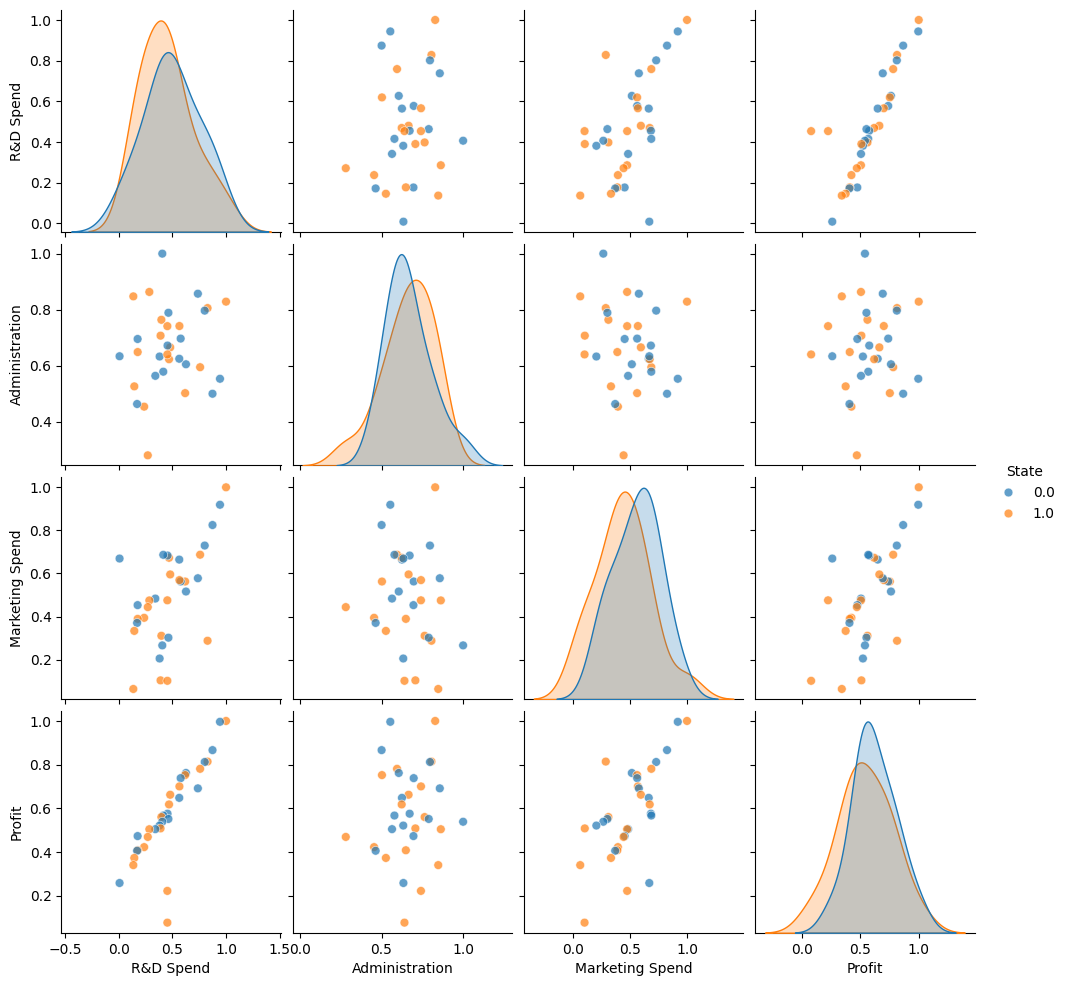

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_fin, hue = 'State', plot_kws={'alpha': 0.7, 's': 40})
plt.show()

In [296]:
triplets = []
headers = list(df_fin.columns.values)
headers.remove('State')
triplets = []
for i in range (4):
    for j in range (4):
        for z in range (4):
            if i != j and i != z and j != z:
                to_append = [headers[i], headers[j], headers[z]]
                to_append.sort()
                to_append = tuple(to_append)
                triplets.append(to_append)
triplets = set(triplets)
triplets = [list(trip) for trip in triplets]
df_proof = df_fin[[c for c in df_fin.columns if c in triplets[0]]]

import matplotlib

def tridimensional_plot(df, triplets, colors):
    matplotlib.rc('xtick', labelsize=5) 
    fig = plt.figure(figsize = (11, 11))
    for i, triplet in enumerate(triplets):
        axs = fig.add_subplot(2, 2, i + 1, projection='3d')
        axs.scatter(df[triplet[0]],df[triplet[1]], df[triplet[2]], c = colors, depthshade=True)
        #fig.colorbar(img, location = 'bottom', label = 'State', aspect = 50)
        axs.set_title(f'{triplet[0]}, {triplet[1]}, {triplet[2]}')
        axs.set_yticklabels([])
        axs.set_xticklabels([])  
        axs.set_zticklabels([])
    plt.show()



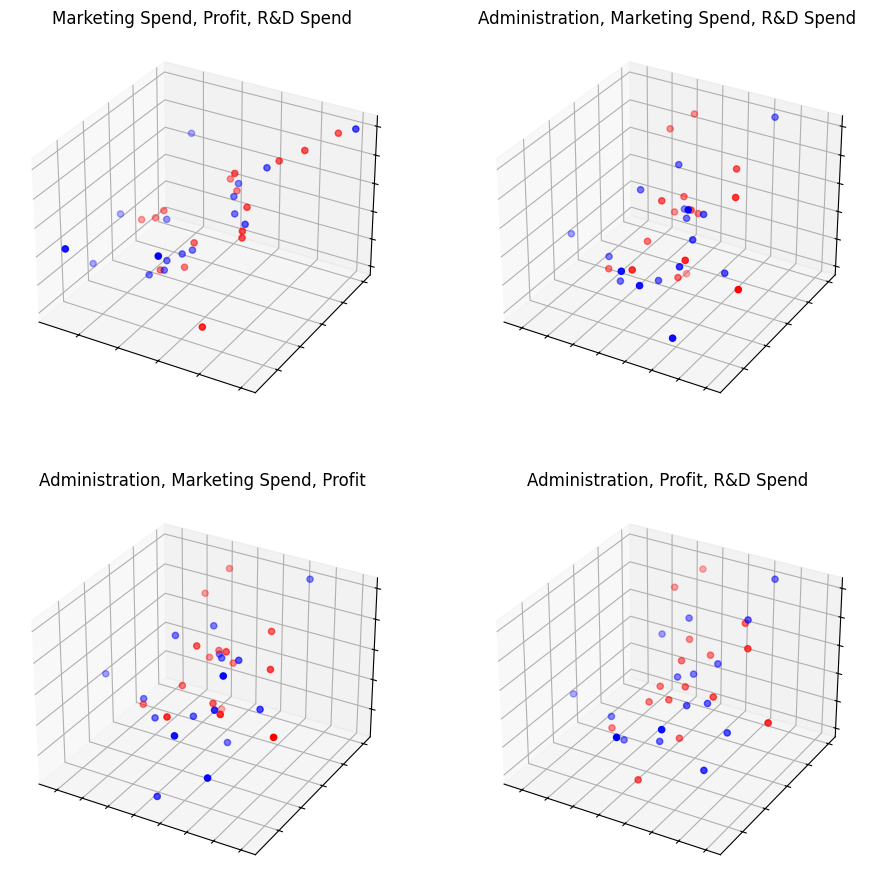

In [298]:
colors = ['b' if s == 1 else 'r' for s in df_fin['State']]
tridimensional_plot(df_fin, triplets, colors)

Not much to undestrand from this graphics. Before moving on I could think that maybe our regression will not be that good since we do not really see any straight line that can divide our data. But we do not demorde because this is only the 2D view of the phenomen so maybe, in higher dimension, there's actually an hyper plane that does its job well. 

***Plot results***

So now we will print the accuracy and plot the results we obtained.

In [23]:
print(accuracy)

0.3333


Okay that's a really low accuracy, that doesn't surprend us too much (we have a very small dataset and it seems also a difficult task to perform seeing the 2d data). We are gonna plot a confusion matrix on the test set.

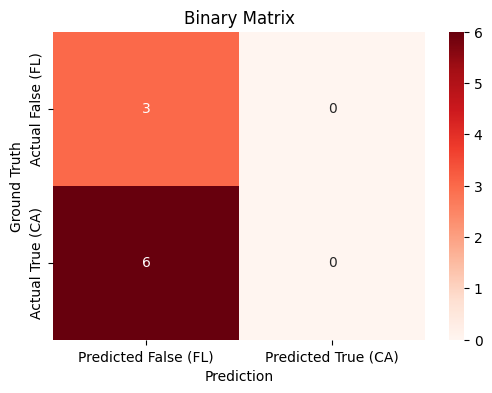

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=True,
            xticklabels=['Predicted False (FL)', 'Predicted True (CA)'],
            yticklabels=['Actual False (FL)', 'Actual True (CA)'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Binary Matrix")
plt.show()

We clearly see that actually, our model, just predicted a single state everytime. It also perform worst than the ground truth (because in this case the ground truth would have been selecting only California and our accuracy would have been of the 66%, that's 100% better).

***Add regularization***

Implement from scratch the regularized logistic regression model (with all the regularization techniques seen during the course).

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from numpy.linalg import inv
from sklearn.metrics import classification_report

def sigmoidM(X, w):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    y = 1/(1+np.exp(-np.matmul(X,w)))
    return y

In [26]:
def LogisticLoss(X, y, w):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    n = np.shape(X)[0]
    cost = -(1/n)*np.sum(y*np.log(sigmoidM(X,w)) + (1-y)*np.log(1-sigmoidM(X,w)))
    return cost

In [27]:
def L1_subgradient(z):
    """
    Compute the subgradient of the absolute value function element-wise.

    Parameters:
    ----------
    z : array-like
        Input array for which the subgradient is calculated.

    Returns:
    ----------
    g : array-like
        Subgradient of the absolute value function applied element-wise to `z`.
    """
    # Create an array g of the same shape as z, initialized with all 1s.
    g = np.ones(z.shape)

    # Check each element of z.
    for i in range(z.shape[0]):
        # If the element is negative, set the corresponding element in g to -1.
        if z[i] < 0.:
            g[i] = -1.0

    # Return the resulting array g, representing the subgradient.
    return g

In [28]:
def LogisticElasticNetLoss(X, y, w, lam, lamr):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    lam : float
        Weight of the L1 and L2 absolut penalty term
    lamr : float
        Weight of the L1 and (1 - lamr) L2 relative penalty term
    """
    return LogisticLoss(X, y, w) + lamr*lam*LA.norm(w,1) + (1-lamr)*lam*LA.norm(w,2)

In [29]:
def GDLogisticElasticNet(X, labels, iter, gamma, lam, lamr):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    labels : array of dim n
        Vector representing the ground truth label of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    lam : float
        Weight of the L1 and L2 absolut penalty term
    lamr : float
        Weight of the L1 and (1 - lamr) L2 relative penalty term
    """
    d = np.shape(X)  # d contains the shape of X, which is a tuple (n, d)
    cost = np.zeros(iter)  # Create an array to store the cost at each iteration
    w = np.random.uniform(0, 0.01, d[1])  # Initialize w with random values
    W = np.zeros((4, iter))  # Create an array to store the weight vectors at each iteration

    for i in range(iter):
        W[:, i] = w  # Store the current weight vector in the W array
        # Update the weight vector using gradient descent
        w = w - gamma *((2/ d[0]) * (np.transpose(X) @ (sigmoidM(X, w) - labels)) +  lamr*lam*w + (1 - lamr)*lam*2*w)
        # Compute and store the logistic loss for the current weight vector
        cost[i] = LogisticElasticNetLoss(X, labels, w, lam, lamr)

    return W, cost

In [30]:
def modelVisualization(X, labels, iter, gamma, lam, lamr, threshold, target_names):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    labels : array of dim n
        Vector representing the ground truth label of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    lam : float
        Weight of the L1 and L2 absolut penalty term
    lamr : float
        Weight of the L1 and (1 - lamr) L2 relative penalty term
    threshold: float
        Threshold for the value to be set as 0 or 1
    target_names: list of string
        Names of the categories
    """
    W, loss = GDLogisticElasticNet(X, labels, iter, gamma, lam, lamr)
    w = W[:, -1]
    y_pred = sigmoidM(X, w)
    y_pred[y_pred < threshold] = 0
    y_pred[y_pred > threshold] = 1
    plt.plot(loss)
    return w, loss

In [31]:
def accuracy(X_test, Y_test, w, threshold):
    accuracy = 0 
    y_pred = sigmoidM(X_test, w)
    y_pred[y_pred < threshold] = 0
    y_pred[y_pred > threshold] = 1
    print(y_pred)
    for i in range (len(Y_test)):
        if Y_test[i] == y_pred[i]:
            accuracy+=1
    return accuracy / len(Y_test)

In [32]:
# Model param
iter = 100 # Number of iteration
gamma = 0.0005 # Learning rate
lam = 5 # Penalty term for the regularization
lamr = 0 # Relativity term for the regularization
threshold = 0.5 # Acceptance threshold
target_names = ['Florida', 'California']

[0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.4444444444444444


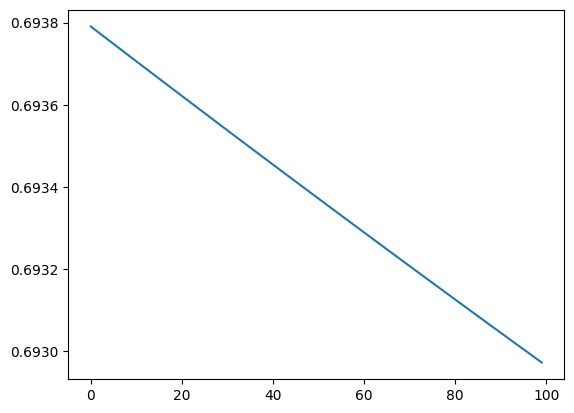

In [33]:
# Model with no regularization (Plain)
lam = 0 # We do not regularize in this case
mdP = modelVisualization(X_train, y_train, iter, gamma, lam, lamr, threshold, target_names)
w = mdP[0]
print(accuracy(X_test, y_test, w, threshold))

[0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.4444444444444444


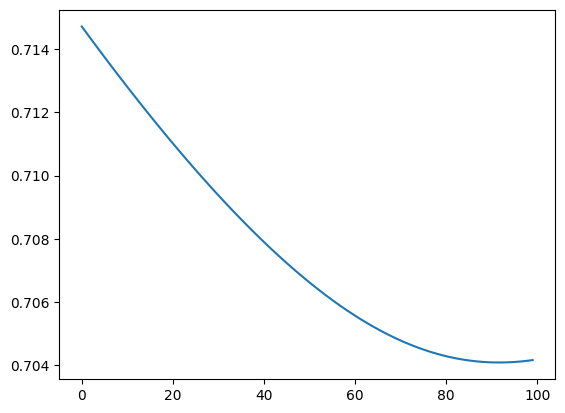

In [34]:
# Model with Ridge
lam = 2
lamr = 0 # We only use L2 penalty term
mdR = modelVisualization(X_train, y_train, iter, gamma, lam, lamr, threshold, target_names)
w = mdR[0]
print(accuracy(X_test, y_test, w, threshold))

[1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.6666666666666666


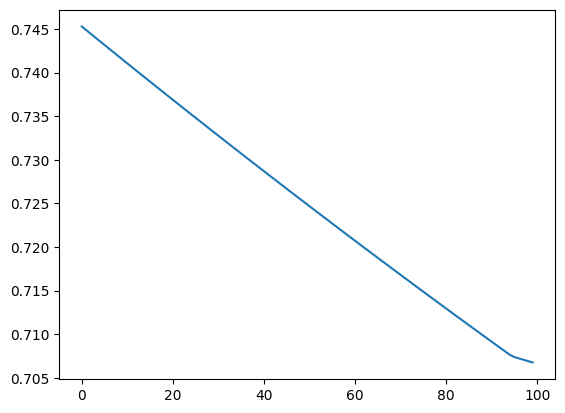

In [35]:
# Model with Lasso
lam = 2
lamr = 1 # We only use L1 penalty term
mdL = modelVisualization(X_train, y_train, iter, gamma, lam, lamr, threshold, target_names)
w = mdL[0]
print(accuracy(X_test, y_test, w, threshold))

[1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.6666666666666666


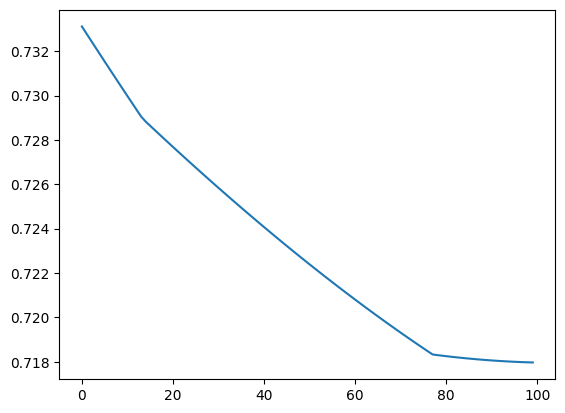

In [36]:
# Elastic Model
lam = 2
lamr = 0.5
mdE = modelVisualization(X_train, y_train, iter, gamma, lam, lamr, threshold, target_names)
w = mdE[0]
print(accuracy(X_test, y_test, w, threshold))

***Model assessment***

Given true and predicted values, compute the most common classification metrics to assess the quality of your predictions.

In [37]:
def predict(X, w, threshold):
    y_pred = sigmoidM(X, w)
    y_pred[y_pred < threshold] = 0  
    y_pred[y_pred >= threshold] = 1
    return y_pred

def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=True,
                xticklabels=['Predicted False (FL)', 'Predicted True (CA)'],
                yticklabels=['Actual False (FL)', 'Actual True (CA)'])
    plt.xlabel("Prediction")
    plt.ylabel("Ground Truth")
    plt.title("Binary Matrix")

    plt.show()

In [38]:
from sklearn.metrics import classification_report
def visualize_metrics(X, y_true, model, threshold):
    w, loss = model
    y_pred = predict(X, w, threshold)

    print(f'prediction : {y_pred}')

    target_names = ['False (FL)', 'True (CA)']
    print(classification_report(y_true, y_pred, target_names=target_names))

    visualize_confusion_matrix(y_test, y_pred)

In [39]:
print(y_test)

[0. 1. 1. 0. 1. 1. 1. 1. 0.]


prediction : [0. 0. 0. 0. 1. 0. 0. 0. 0.]
              precision    recall  f1-score   support

  False (FL)       0.38      1.00      0.55         3
   True (CA)       1.00      0.17      0.29         6

    accuracy                           0.44         9
   macro avg       0.69      0.58      0.42         9
weighted avg       0.79      0.44      0.37         9



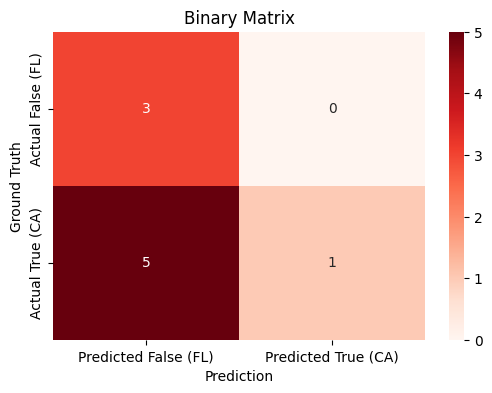

In [40]:
visualize_metrics(X_test, y_test, mdP, threshold)

prediction : [0. 0. 0. 0. 1. 0. 0. 0. 0.]
              precision    recall  f1-score   support

  False (FL)       0.38      1.00      0.55         3
   True (CA)       1.00      0.17      0.29         6

    accuracy                           0.44         9
   macro avg       0.69      0.58      0.42         9
weighted avg       0.79      0.44      0.37         9



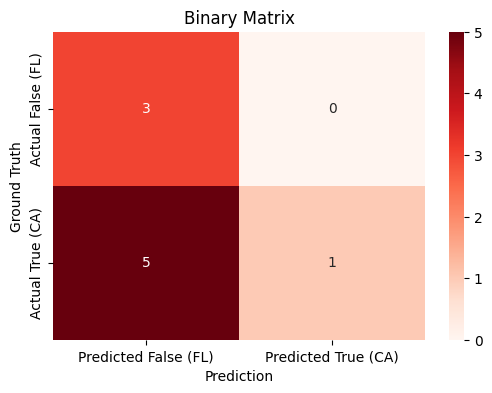

In [41]:
visualize_metrics(X_test, y_test, mdR, threshold)

prediction : [1. 1. 1. 1. 1. 1. 1. 1. 1.]
              precision    recall  f1-score   support

  False (FL)       0.00      0.00      0.00         3
   True (CA)       0.67      1.00      0.80         6

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



c:\Users\39346\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\39346\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\39346\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

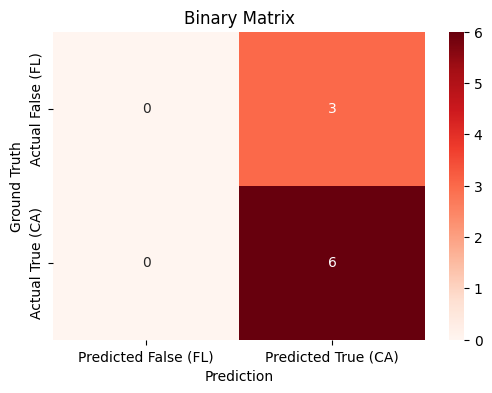

In [42]:
visualize_metrics(X_test, y_test, mdL, threshold)

prediction : [1. 1. 1. 1. 1. 1. 1. 1. 1.]
              precision    recall  f1-score   support

  False (FL)       0.00      0.00      0.00         3
   True (CA)       0.67      1.00      0.80         6

    accuracy                           0.67         9
   macro avg       0.33      0.50      0.40         9
weighted avg       0.44      0.67      0.53         9



c:\Users\39346\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\39346\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\39346\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

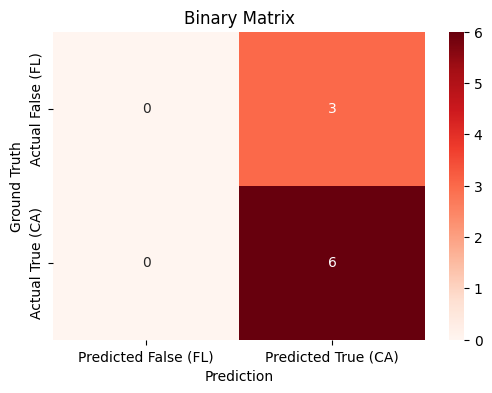

In [43]:
visualize_metrics(X_test, y_test, mdE, threshold)

***ROC curve***

Implement a function for producing the Receiver Operating Characteristic (ROC) curve.

Given true and predicted values, plot the ROC curve using your implemented function.

In [44]:
def compute_tpr_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp + fn), fp/(fp + tn)

In [46]:
verbose = False

In [49]:
def roc_curve(X_test, y_test, w, model_name = ''):

    thresholds = list(sigmoidM(X_test, w))
    thresholds.append(1)
    thresholds.sort(reverse=True)

    if verbose:
        print(thresholds)

    tprs = []
    fprs = []
    
    for thr in thresholds:
        y_pred = predict(X_test, w, thr)
        tpr, fpr = compute_tpr_fpr(y_test, y_pred)
        if verbose:
            print(thr)
            print(y_pred)
            print(f'TPR : {tpr} \nFPR : {fpr}')
            print()
        tprs.append(tpr)
        fprs.append(fpr)

    plt.xlabel("FPR", fontsize = 'large', color = 'b')
    plt.ylabel("TPR", fontsize = 'large', color = 'b')
    plt.title(f"ROC Curve {model_name}", fontsize = 'xx-large', color = 'r')
    plt.plot([0, 1], [0, 1],'k')
    plt.plot(fprs, tprs)
    plt.scatter(fprs, tprs)
    plt.show()

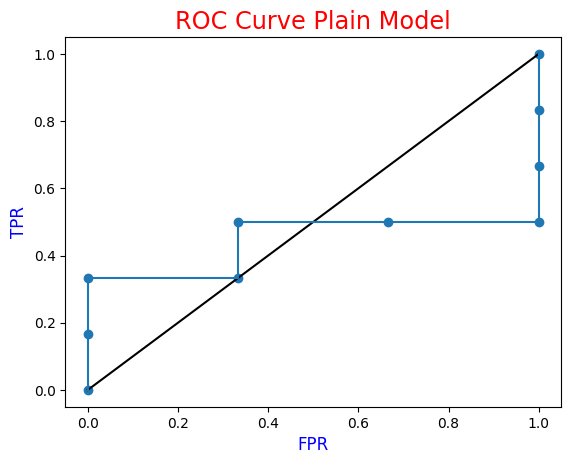

In [51]:
w = mdP[0]
roc_curve(X_test, y_test, w, 'Plain Model')

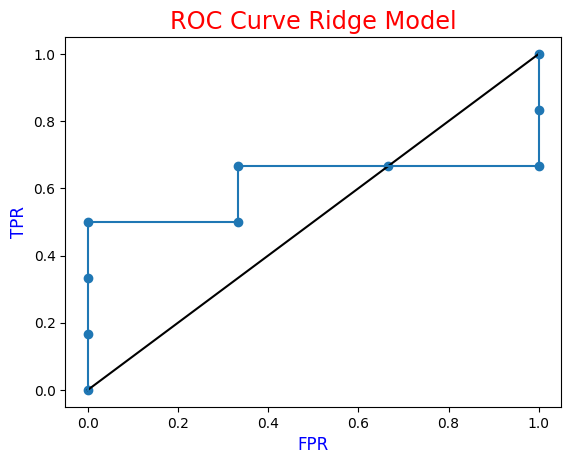

In [52]:
w = mdR[0]
roc_curve(X_test, y_test, w, 'Ridge Model')

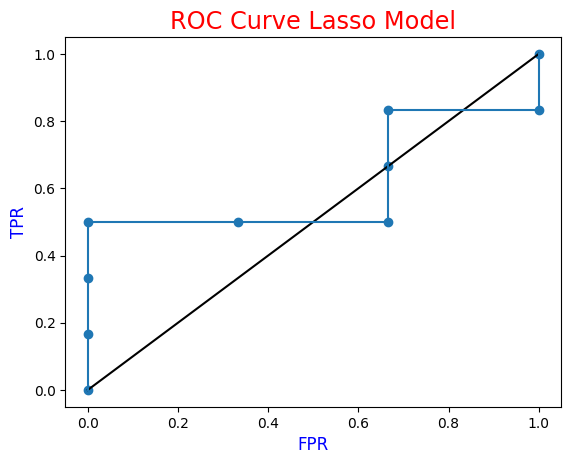

In [53]:
w = mdL[0]
roc_curve(X_test, y_test, w, 'Lasso Model')

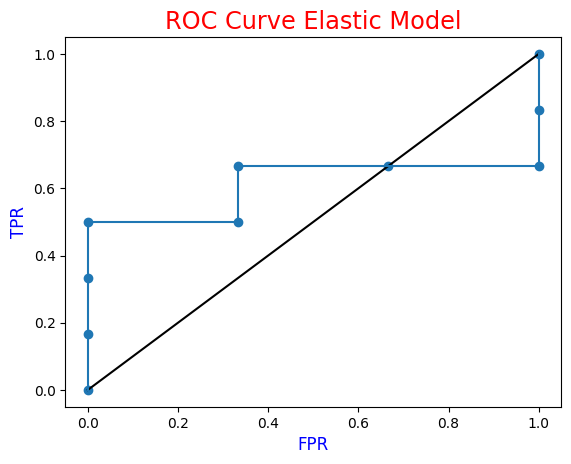

In [54]:
w = mdE[0]
roc_curve(X_test, y_test, w, 'Elastic Model')